<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !mkdir data
# !gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
# !gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
# !unzip -o test.zip -d data
# !unzip -o train.zip -d data

# !git clone https://github.com/Mamiglia/challenge.git

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import math
import torch.nn.functional as F 

from src.common import load_data, prepare_train_data, generate_submission

In [3]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 40
BATCH_SIZE = 128
LR = 1e-4

DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


In [4]:
class KernelAdapter(nn.Module):
    """Base kernel adapter with Random Fourier Features"""
    def __init__(self, d_in, d_out, n_feats=256, sigma=0.8, dropout=0.1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_in, n_feats) / sigma)
        self.b = nn.Parameter(torch.rand(n_feats) * 2 * math.pi)
        self.fc = nn.Linear(n_feats, d_out)
        self.drop = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x_proj = torch.cos(x @ self.W + self.b)
        x_proj = self.drop(x_proj)
        out = self.fc(x_proj)
        return F.normalize(out, dim=-1)


class KernelResidualAdapter(nn.Module):
    """Kernel adapter + residual MLP + local geometric correction"""
    def __init__(self, d_in=1024, d_out=1536, n_feats=512, sigma=0.7):
        super().__init__()
        self.kernel = KernelAdapter(d_in, d_out, n_feats, sigma)
        self.residual = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.GELU(),
            nn.Linear(d_out, d_out)
        )
        # Local geometric correction (small feature-wise modulation)
        self.local = nn.Sequential(
            nn.Linear(d_in, d_out // 8),
            nn.GELU(),
            nn.Linear(d_out // 8, d_out),
            nn.Tanh()
        )
        self.norm = nn.LayerNorm(d_out)
        self.scale = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        base = self.kernel(x)
        res = self.residual(x)
        local = self.local(x) * 0.3  # local correction term (scaled)
        scale = self.scale(x)
        out = (base + 0.5 * res + local) * scale
        out = self.norm(out)
        return F.normalize(out, dim=-1)



In [ ]:
def hybrid_loss(z_pred, z_true, temperature=0.07, alpha=0.7, beta=0.25, gamma=0.05):
    mse = F.mse_loss(z_pred, z_true)
    cos = (1 - F.cosine_similarity(z_pred, z_true, dim=-1).mean())
    sim = (z_pred @ z_true.T) / temperature
    labels = torch.arange(sim.size(0), device=z_pred.device)
    contrast = F.cross_entropy(sim, labels)
    return alpha*mse + beta*cos + gamma*contrast


In [6]:
def metric_reg(z_pred, z_text, k=5):
    """Forza coerenza locale tra spazi: se due caption sono simili in A, lo siano anche in B."""
    with torch.no_grad():
        sims_text = (z_text @ z_text.T)
        idx = sims_text.topk(k, dim=1).indices
        mask = torch.zeros_like(sims_text)
        mask.scatter_(1, idx, 1.0)
    sims_pred = (z_pred @ z_pred.T)
    return ((mask * (sims_pred - sims_text))**2).mean()


In [7]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, device, epochs, lr):
    """Train the MLP model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2)
            outputs = model(X_batch)

            # loss = F.mse_loss(outputs, y_batch)
            loss = hybrid_loss(outputs, y_batch) + 0.2 * metric_reg(outputs, X_batch)
            with torch.no_grad():
                sims = (outputs @ y_batch.T)
                hard_idx = sims.topk(k=5, dim=1).indices  # top-5 simili (include gt)

            # penalizza i negativi più simili
            pos = torch.arange(sims.size(0), device=outputs.device)
            mask = torch.zeros_like(sims)
            mask.scatter_(1, hard_idx, 1.0)
            contrast = -torch.log_softmax(sims / 0.07, dim=1)[pos]
            loss = loss + 0.1 * (contrast[mask.sum(1) > 0]).mean()


            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                # loss = F.mse_loss(outputs, y_batch)
                loss = hybrid_loss(outputs, y_batch) + 0.2 * metric_reg(outputs, X_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")
            
        scheduler.step()

    return model


In [8]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

# X = F.normalize(X, dim=-1)
# y = F.normalize(y, dim=-1)
# X = (X - X.mean(0)) / X.std(0)
# y = (y - y.mean(0)) / y.std(0)

def whiten(X):
    X = X - X.mean(0)
    cov = X.T @ X / (X.shape[0]-1)
    eigvals, eigvecs = torch.linalg.eigh(cov)
    W = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals + 1e-6)) @ eigvecs.T
    return X @ W

X = whiten(X)
y = whiten(y)
X = F.normalize(X, dim=-1)
y = F.normalize(y, dim=-1)


DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

(125000,)
Train data: 125000 captions, 125000 images


(1536, 1024)

In [9]:
model = KernelResidualAdapter().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))


   Parameters: 7,318,720

3. Training...


Epoch 1/40: 100%|██████████| 879/879 [00:26<00:00, 33.03it/s]


Epoch 1: Train Loss = 0.968104, Val Loss = 0.451639
  ✓ Saved best model (val_loss=0.451639)


Epoch 2/40: 100%|██████████| 879/879 [00:24<00:00, 35.90it/s]


Epoch 2: Train Loss = 0.876283, Val Loss = 0.388258
  ✓ Saved best model (val_loss=0.388258)


Epoch 3/40: 100%|██████████| 879/879 [00:24<00:00, 36.16it/s]


Epoch 3: Train Loss = 0.837302, Val Loss = 0.378843
  ✓ Saved best model (val_loss=0.378843)


Epoch 4/40: 100%|██████████| 879/879 [00:24<00:00, 36.02it/s]


Epoch 4: Train Loss = 0.826516, Val Loss = 0.376333
  ✓ Saved best model (val_loss=0.376333)


Epoch 5/40: 100%|██████████| 879/879 [00:24<00:00, 35.28it/s]


Epoch 5: Train Loss = 0.821040, Val Loss = 0.375514
  ✓ Saved best model (val_loss=0.375514)


Epoch 6/40: 100%|██████████| 879/879 [00:25<00:00, 34.15it/s]


Epoch 6: Train Loss = 0.817609, Val Loss = 0.375366
  ✓ Saved best model (val_loss=0.375366)


Epoch 7/40: 100%|██████████| 879/879 [00:24<00:00, 35.36it/s]


Epoch 7: Train Loss = 0.815218, Val Loss = 0.375447


Epoch 8/40: 100%|██████████| 879/879 [00:24<00:00, 35.26it/s]


Epoch 8: Train Loss = 0.813479, Val Loss = 0.375629


Epoch 9/40: 100%|██████████| 879/879 [00:24<00:00, 35.70it/s]


Epoch 9: Train Loss = 0.812095, Val Loss = 0.375826


Epoch 10/40: 100%|██████████| 879/879 [00:24<00:00, 35.83it/s]


Epoch 10: Train Loss = 0.810949, Val Loss = 0.376030


Epoch 11/40: 100%|██████████| 879/879 [00:24<00:00, 36.00it/s]


Epoch 11: Train Loss = 0.809927, Val Loss = 0.376234


Epoch 12/40: 100%|██████████| 879/879 [00:24<00:00, 36.24it/s]


Epoch 12: Train Loss = 0.809152, Val Loss = 0.376456


Epoch 13/40: 100%|██████████| 879/879 [00:24<00:00, 36.09it/s]


Epoch 13: Train Loss = 0.808372, Val Loss = 0.376633


Epoch 14/40: 100%|██████████| 879/879 [00:24<00:00, 36.03it/s]


Epoch 14: Train Loss = 0.807749, Val Loss = 0.376819


Epoch 15/40: 100%|██████████| 879/879 [00:24<00:00, 35.29it/s]


Epoch 15: Train Loss = 0.807153, Val Loss = 0.376992


Epoch 16/40: 100%|██████████| 879/879 [00:24<00:00, 35.72it/s]


Epoch 16: Train Loss = 0.806593, Val Loss = 0.377141


Epoch 17/40: 100%|██████████| 879/879 [00:24<00:00, 35.57it/s]


Epoch 17: Train Loss = 0.806164, Val Loss = 0.377278


Epoch 18/40: 100%|██████████| 879/879 [00:25<00:00, 34.96it/s]


Epoch 18: Train Loss = 0.805702, Val Loss = 0.377415


Epoch 19/40: 100%|██████████| 879/879 [00:24<00:00, 35.45it/s]


Epoch 19: Train Loss = 0.805281, Val Loss = 0.377534


Epoch 20/40: 100%|██████████| 879/879 [00:24<00:00, 35.80it/s]


Epoch 20: Train Loss = 0.804897, Val Loss = 0.377641


Epoch 21/40: 100%|██████████| 879/879 [00:25<00:00, 34.98it/s]


Epoch 21: Train Loss = 0.804467, Val Loss = 0.377728


Epoch 22/40: 100%|██████████| 879/879 [00:24<00:00, 35.35it/s]


Epoch 22: Train Loss = 0.804129, Val Loss = 0.377843


Epoch 23/40: 100%|██████████| 879/879 [00:25<00:00, 35.15it/s]


Epoch 23: Train Loss = 0.803898, Val Loss = 0.377891


Epoch 24/40: 100%|██████████| 879/879 [00:24<00:00, 35.79it/s]


Epoch 24: Train Loss = 0.803605, Val Loss = 0.377968


Epoch 25/40: 100%|██████████| 879/879 [00:24<00:00, 35.59it/s]


Epoch 25: Train Loss = 0.803341, Val Loss = 0.378044


Epoch 26/40: 100%|██████████| 879/879 [00:25<00:00, 34.13it/s]


Epoch 26: Train Loss = 0.803034, Val Loss = 0.378066


Epoch 27/40: 100%|██████████| 879/879 [00:25<00:00, 33.86it/s]


Epoch 27: Train Loss = 0.802753, Val Loss = 0.378107


Epoch 28/40: 100%|██████████| 879/879 [00:24<00:00, 36.23it/s]


Epoch 28: Train Loss = 0.802530, Val Loss = 0.378110


Epoch 29/40: 100%|██████████| 879/879 [00:24<00:00, 35.46it/s]


Epoch 29: Train Loss = 0.802330, Val Loss = 0.378163


Epoch 30/40: 100%|██████████| 879/879 [00:24<00:00, 35.73it/s]


Epoch 30: Train Loss = 0.802099, Val Loss = 0.378180


Epoch 31/40: 100%|██████████| 879/879 [00:24<00:00, 36.09it/s]


Epoch 31: Train Loss = 0.801908, Val Loss = 0.378245


Epoch 32/40: 100%|██████████| 879/879 [00:24<00:00, 36.16it/s]


Epoch 32: Train Loss = 0.801624, Val Loss = 0.378248


Epoch 33/40: 100%|██████████| 879/879 [00:24<00:00, 35.66it/s]


Epoch 33: Train Loss = 0.801488, Val Loss = 0.378270


Epoch 34/40: 100%|██████████| 879/879 [00:24<00:00, 35.76it/s]


Epoch 34: Train Loss = 0.801268, Val Loss = 0.378281


Epoch 35/40: 100%|██████████| 879/879 [00:24<00:00, 35.68it/s]


Epoch 35: Train Loss = 0.801032, Val Loss = 0.378297


Epoch 36/40: 100%|██████████| 879/879 [00:24<00:00, 35.99it/s]


Epoch 36: Train Loss = 0.800870, Val Loss = 0.378328


Epoch 37/40: 100%|██████████| 879/879 [00:24<00:00, 35.95it/s]


Epoch 37: Train Loss = 0.800655, Val Loss = 0.378339


Epoch 38/40: 100%|██████████| 879/879 [00:24<00:00, 35.68it/s]


Epoch 38: Train Loss = 0.800428, Val Loss = 0.378316


Epoch 39/40: 100%|██████████| 879/879 [00:24<00:00, 35.81it/s]


Epoch 39: Train Loss = 0.800262, Val Loss = 0.378343


Epoch 40/40: 100%|██████████| 879/879 [00:24<00:00, 35.93it/s]


Epoch 40: Train Loss = 0.800084, Val Loss = 0.378354


<All keys matched successfully>

## Evaluation

### Visualize

/Users/valeriosantini/Desktop/Challenge AML/challenge-master/challenge/src/eval/visualize.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4422.)
  similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()


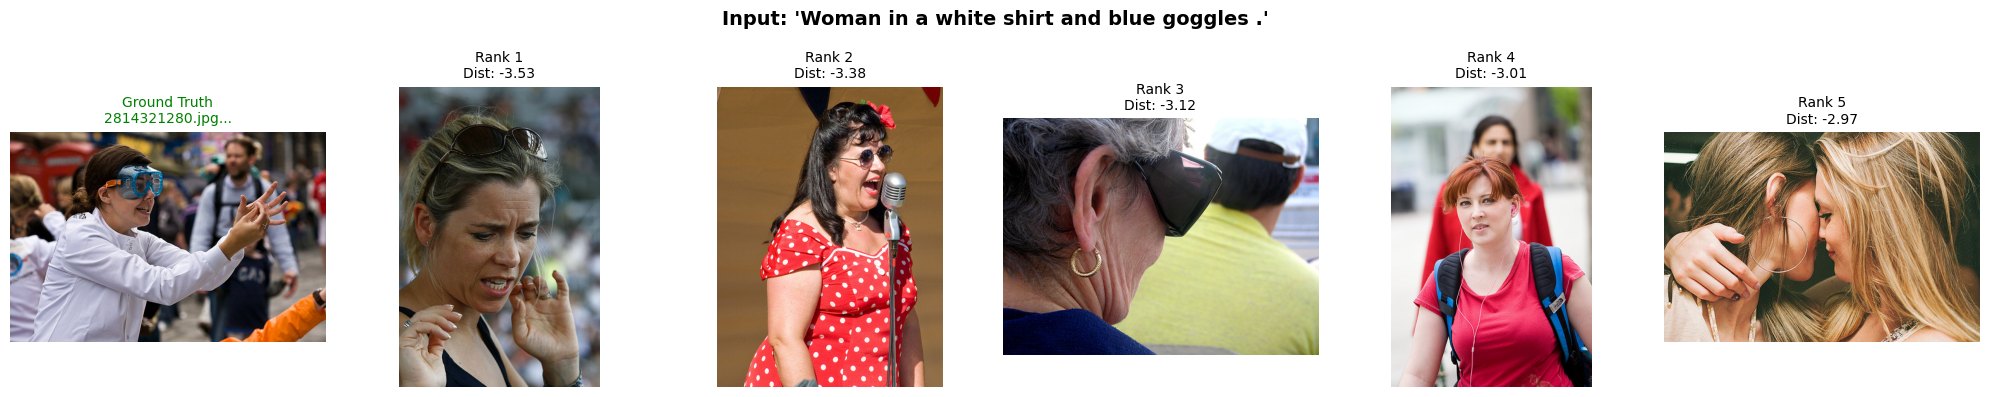

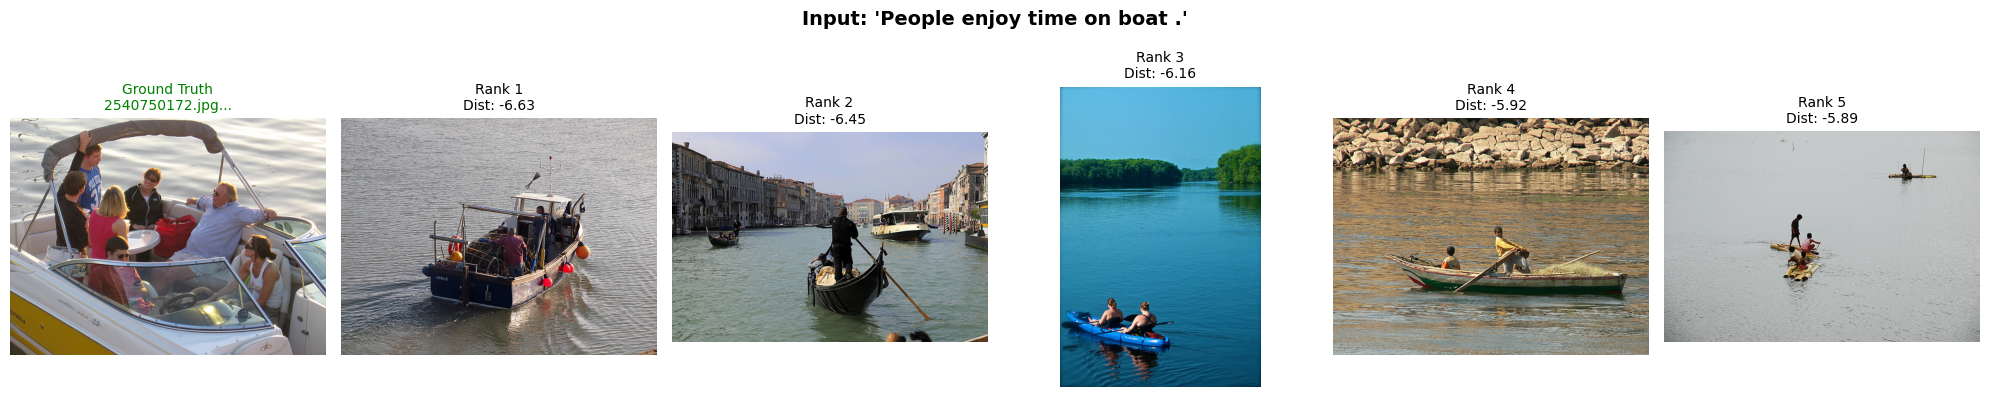

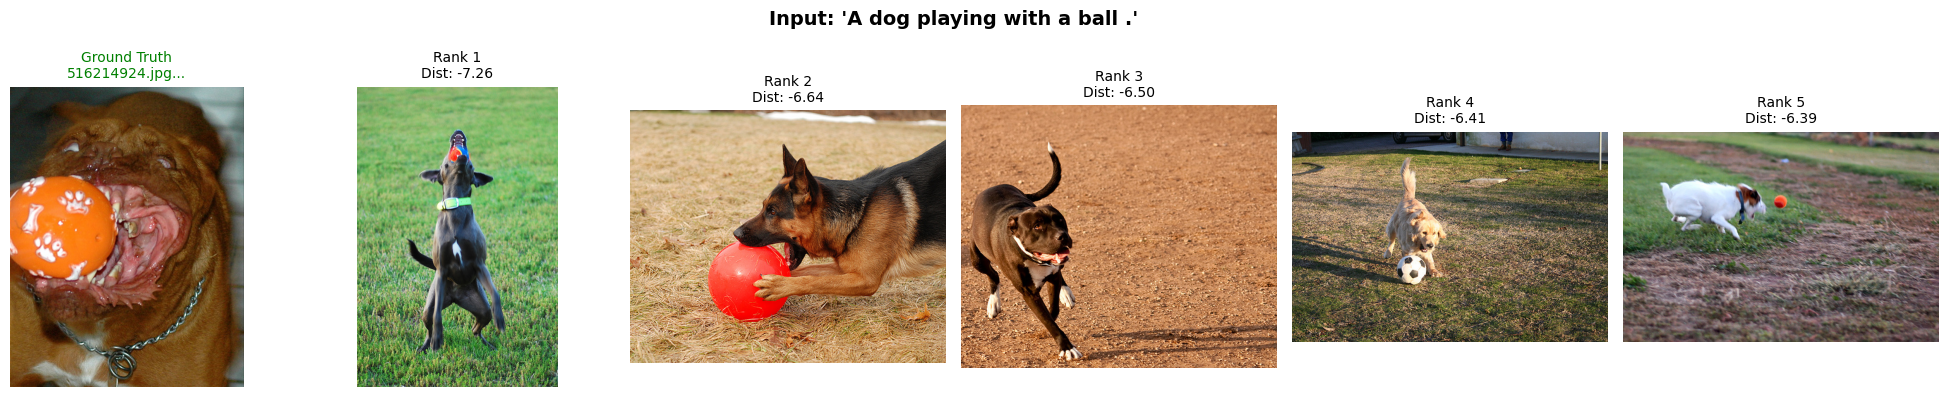

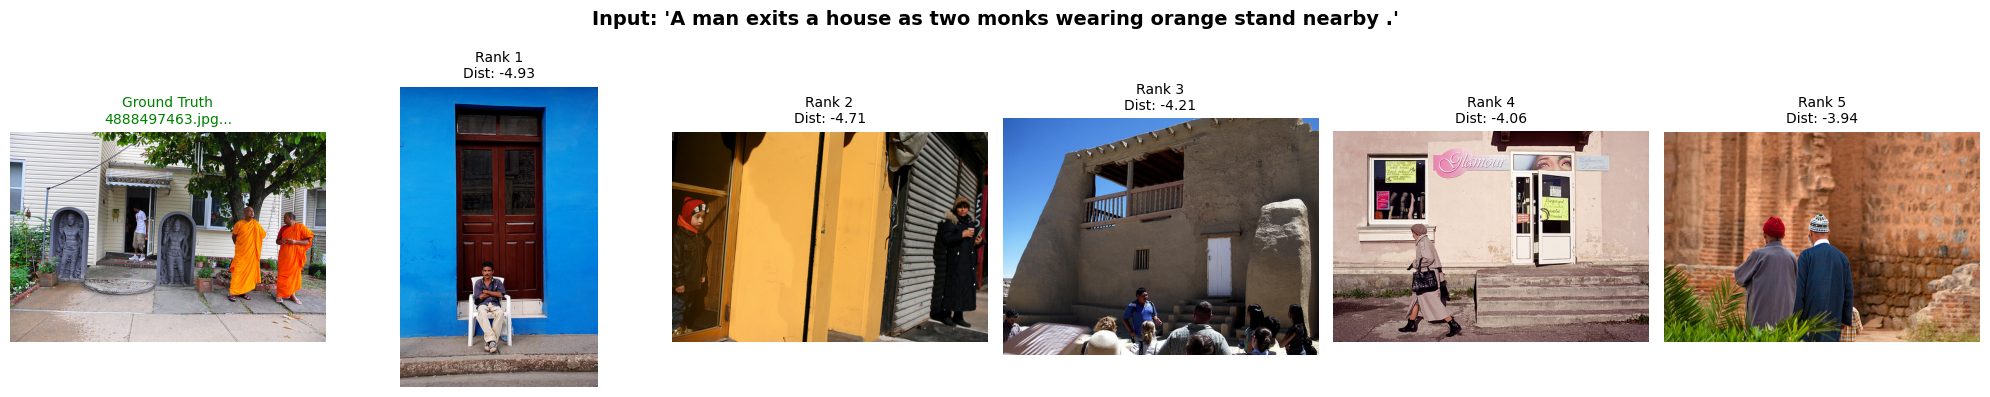

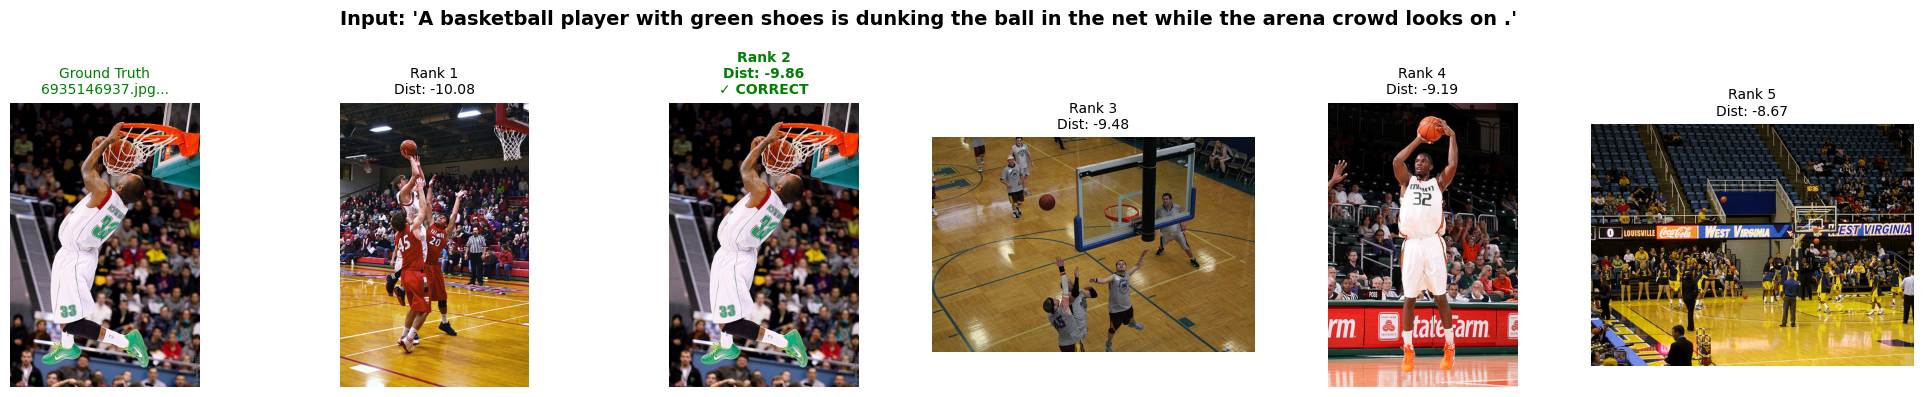

In [10]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [11]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth


In [12]:
# --- Evaluate retrieval performance ---
from challenge.src.eval import evaluate_retrieval  # adattalo al tuo path
import numpy as np

model.eval()
with torch.no_grad():
    z_pred_val = model(X_val.to(DEVICE)).cpu()

# ground truth embeddings (target images)
z_img_val = y_val.cpu()
gt_indices = np.arange(len(z_img_val))  # ogni caption ha la sua immagine target

results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=z_img_val,
    gt_indices=gt_indices,
    max_indices=50,
    batch_size=128
)

print("\n=== Retrieval evaluation (validation set) ===")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")



=== Retrieval evaluation (validation set) ===
         mrr: 0.4125
        ndcg: 0.5502
 recall_at_1: 0.1765
 recall_at_3: 0.5266
 recall_at_5: 0.8737
recall_at_10: 0.9436
recall_at_50: 0.9916
     l2_dist: 1.3081
